# Importing relevant libraries

In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn tqdm

In [2]:
# install cu129 torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129


# Importing relevant libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Download and Import Dataset

### Run the first 2 cells if running on Colab

In [1]:
#!pip install kaggle unzip

# # Assuming you have your kaggle.json in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d shayanfazeli/heartbeat
# !unzip heartbeat.zip

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\leona\miniconda3\envs\sc4001\Scripts\kaggle.exe\__main__.py", line 6, in <module>
    sys.exit(main())
             ~~~~^^
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\cli.py", line 68, in main
    out = args.func(**command_args)
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Download the dataset
#!kaggle datasets download -d sadmansakib7/ecg-arrhythmia-classification-dataset
#!unzip ecg-arrhythmia-classification-dataset.zip

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\leona\miniconda3\envs\sc4001\Scripts\kaggle.exe\__main__.py", line 6, in <module>
    sys.exit(main())
             ~~~~^^
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\cli.py", line 68, in main
    out = args.func(**command_args)
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd

mitbih_train = pd.read_csv('mitbih_train.csv', header=None) # 80%
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)   # 20%

In [3]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [4]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test



In [5]:
def analyze_dataset(file_path, name):
    """
    Analyze a dataset file and print information about its structure
    """
    print(f"\nAnalyzing {name} dataset...")
    df = pd.read_csv(file_path, header=None, nrows=5)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

In [6]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'mitbih_train.csv'
mitbih_test_path = 'mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [7]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


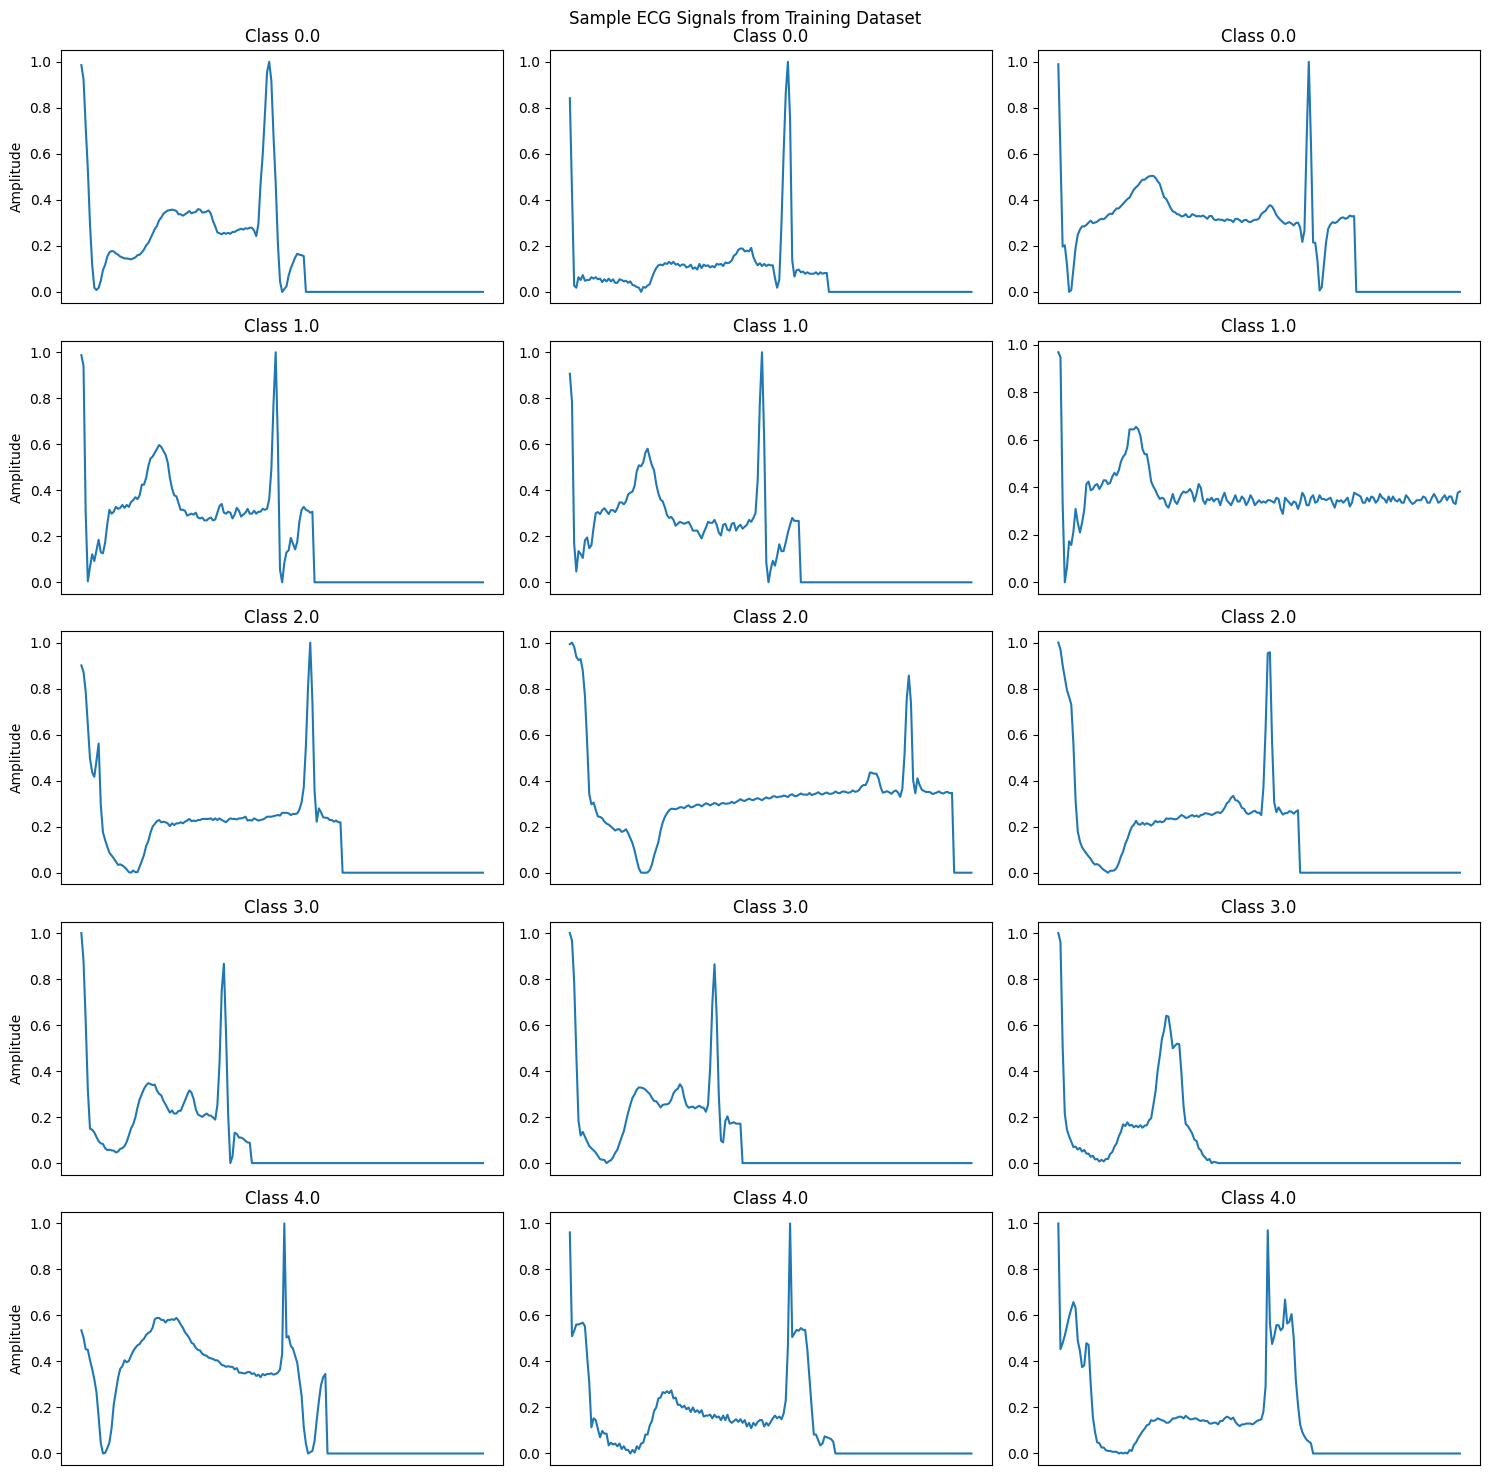


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [8]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ECG Dataset on RNN Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECG_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_heads=4, num_classes=5, dropout=0.3):
        """
        Hierarchical Attention-Gated RNN for ECG classification.

        Args:
            input_size (int): Number of input features per timestep
            hidden_size (int): Hidden state size of RNNs
            num_layers (int): Number of RNN layers
            num_heads (int): Number of attention heads
            num_classes (int): Number of output classes
            dropout (float): Dropout rate
        """
        super(ECG_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # --- 1. Short-term RNN ---
        self.short_rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 2. Long-term RNN ---
        self.long_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 3. Gated Residual Fusion ---
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.Sigmoid()
        )

        # --- 4. Multi-Head Attention ---
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )
            for _ in range(num_heads)
        ])

        # --- 5. Context Refinement RNN ---
        self.context_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 6. Classification Head ---
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # --- Short-term encoding ---
        short_out, _ = self.short_rnn(x)  # (b, t, 2H)

        # --- Long-term encoding ---
        long_out, _ = self.long_rnn(short_out)  # (b, t, 2H)

        # --- Gated fusion of short- and long-term features ---
        combined = torch.cat([short_out, long_out], dim=-1)
        gate = self.gate(combined)  # (b, t, 2H)
        fused = gate * short_out + (1 - gate) * long_out  # Adaptive residual fusion

        # --- Multi-head attention ---
        attn_outputs = []
        for head in self.attn_heads:
            weights = head(fused)                # (b, t, 1)
            weights = F.softmax(weights, dim=1)  # normalize
            context = torch.sum(weights * fused, dim=1)  # (b, 2H)
            attn_outputs.append(context)

        # Concatenate multiple attention heads
        multihead_context = torch.stack(attn_outputs, dim=1)  # (b, heads, 2H)

        # --- Context refinement RNN ---
        refined, _ = self.context_rnn(multihead_context)  # (b, heads, 2H)
        refined = torch.mean(refined, dim=1)              # global fusion

        # --- Classification ---
        out = self.fc(refined)
        return out


In [10]:
# Improved training configuration
def get_training_config():
    """
    Returns improved training configuration with:
    - Cyclical learning rates
    - Gradual warmup
    - Label smoothing
    - Mixed precision training
    """
    config = {
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,  # Lower initial learning rate
                'max_lr': 3e-3,      # Maximum learning rate for cyclical schedule
                'batch_size': 64,    # Increased batch size
                'num_epochs': 100,   # More epochs for gradual learning
                'warmup_epochs': 5,  # Gradual warmup
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,  # Increased weight decay
                'gradient_clip_val': 0.5,
            }
        }
    }
    return config

In [11]:
class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [12]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(1)
        target_one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        smoothed_target = target_one_hot * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-smoothed_target * torch.log_softmax(pred, dim=1), dim=1))

In [13]:
def get_training_config():
    """
    Returns improved training configuration for both RNN and CNN models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
            }
        }
    }
    return config

In [14]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)

# Get recommended training configurations
config = get_training_config()

In [15]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs robustly (model may return logits or (logits, extra))
            result = self.model(batch_X)
            outputs = result[0] if isinstance(result, (tuple, list)) else result

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process"""
        print(f"\nStarting training for {self.model_name}...")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()  # Removed val_loss parameter
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')

        # Save final model
        self.save_model('rnn_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()


In [18]:
def train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train both RNN and CNN models"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Get configurations
    config = get_training_config()

    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    batch_size = config['RNN']['training_params']['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize models
    rnn_model = ECG_RNN(**config['RNN']['model_params'])

    # Initialize criterion with label smoothing
    rnn_criterion = SmoothCrossEntropyLoss(smoothing=config['RNN']['training_params']['label_smoothing'])

    # Train RNN
    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name='RNN',
        device=device,
        criterion=rnn_criterion,
        config=config['RNN']['training_params']
    )
    rnn_trainer.train(
        train_loader,
        val_loader,
        config['RNN']['training_params']['num_epochs']
    )
    rnn_trainer.plot_training_history()
    rnn_trainer.evaluate(test_loader)

    return rnn_trainer


Updated configuration:
Number of classes: 5
Sequence length: 187
Using device: cuda

Starting training for RNN...


Training: 100%|██████████| 1232/1232 [00:10<00:00, 117.80it/s]




Epoch [1/100]
Train Loss: 0.7674, Train Acc: 85.05%
Val Loss: 0.6786, Val Acc: 87.43%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.6786)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.12it/s]




Epoch [2/100]
Train Loss: 0.5986, Train Acc: 92.18%
Val Loss: 0.5377, Val Acc: 94.11%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.5377)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.57it/s]




Epoch [3/100]
Train Loss: 0.5468, Train Acc: 94.21%
Val Loss: 0.5131, Val Acc: 95.18%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.5131)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.65it/s]




Epoch [4/100]
Train Loss: 0.5093, Train Acc: 95.45%
Val Loss: 0.4762, Val Acc: 96.48%
Learning Rate: 0.002420
New best model saved! (Val Loss: 0.4762)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.82it/s]




Epoch [5/100]
Train Loss: 0.4805, Train Acc: 96.58%
Val Loss: 0.4527, Val Acc: 97.51%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4527)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.64it/s]




Epoch [6/100]
Train Loss: 0.4706, Train Acc: 96.93%
Val Loss: 0.4559, Val Acc: 97.43%
Learning Rate: 0.002999


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.03it/s]




Epoch [7/100]
Train Loss: 0.4609, Train Acc: 97.32%
Val Loss: 0.4541, Val Acc: 97.41%
Learning Rate: 0.002997


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.12it/s]



Epoch [8/100]
Train Loss: 0.4528, Train Acc: 97.54%
Val Loss: 0.4505, Val Acc: 97.53%
Learning Rate: 0.002993
New best model saved! (Val Loss: 0.4505)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.65it/s]




Epoch [9/100]
Train Loss: 0.4496, Train Acc: 97.72%
Val Loss: 0.4413, Val Acc: 97.93%
Learning Rate: 0.002987
New best model saved! (Val Loss: 0.4413)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.91it/s]




Epoch [10/100]
Train Loss: 0.4449, Train Acc: 97.89%
Val Loss: 0.4394, Val Acc: 97.90%
Learning Rate: 0.002980
New best model saved! (Val Loss: 0.4394)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.98it/s]




Epoch [11/100]
Train Loss: 0.4401, Train Acc: 98.07%
Val Loss: 0.4373, Val Acc: 98.01%
Learning Rate: 0.002972
New best model saved! (Val Loss: 0.4373)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.92it/s]




Epoch [12/100]
Train Loss: 0.4358, Train Acc: 98.25%
Val Loss: 0.4392, Val Acc: 97.97%
Learning Rate: 0.002961


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.33it/s]




Epoch [13/100]
Train Loss: 0.4337, Train Acc: 98.32%
Val Loss: 0.4371, Val Acc: 98.12%
Learning Rate: 0.002950
New best model saved! (Val Loss: 0.4371)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.87it/s]




Epoch [14/100]
Train Loss: 0.4319, Train Acc: 98.41%
Val Loss: 0.4346, Val Acc: 98.12%
Learning Rate: 0.002936
New best model saved! (Val Loss: 0.4346)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.82it/s]




Epoch [15/100]
Train Loss: 0.4302, Train Acc: 98.48%
Val Loss: 0.4377, Val Acc: 98.08%
Learning Rate: 0.002921


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.58it/s]




Epoch [16/100]
Train Loss: 0.4276, Train Acc: 98.56%
Val Loss: 0.4418, Val Acc: 98.01%
Learning Rate: 0.002905


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.65it/s]




Epoch [17/100]
Train Loss: 0.4253, Train Acc: 98.65%
Val Loss: 0.4312, Val Acc: 98.25%
Learning Rate: 0.002887
New best model saved! (Val Loss: 0.4312)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.05it/s]




Epoch [18/100]
Train Loss: 0.4243, Train Acc: 98.70%
Val Loss: 0.4375, Val Acc: 98.00%
Learning Rate: 0.002868


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.96it/s]




Epoch [19/100]
Train Loss: 0.4232, Train Acc: 98.71%
Val Loss: 0.4282, Val Acc: 98.32%
Learning Rate: 0.002847
New best model saved! (Val Loss: 0.4282)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.78it/s]




Epoch [20/100]
Train Loss: 0.4200, Train Acc: 98.84%
Val Loss: 0.4303, Val Acc: 98.33%
Learning Rate: 0.002825


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.25it/s]



Epoch [21/100]
Train Loss: 0.4200, Train Acc: 98.86%
Val Loss: 0.4301, Val Acc: 98.23%
Learning Rate: 0.002802


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.04it/s]



Epoch [22/100]
Train Loss: 0.4182, Train Acc: 98.91%
Val Loss: 0.4273, Val Acc: 98.48%
Learning Rate: 0.002777
New best model saved! (Val Loss: 0.4273)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.86it/s]




Epoch [23/100]
Train Loss: 0.4177, Train Acc: 98.92%
Val Loss: 0.4261, Val Acc: 98.53%
Learning Rate: 0.002751
New best model saved! (Val Loss: 0.4261)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.47it/s]




Epoch [24/100]
Train Loss: 0.4156, Train Acc: 99.00%
Val Loss: 0.4249, Val Acc: 98.52%
Learning Rate: 0.002723
New best model saved! (Val Loss: 0.4249)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.13it/s]




Epoch [25/100]
Train Loss: 0.4148, Train Acc: 99.02%
Val Loss: 0.4241, Val Acc: 98.61%
Learning Rate: 0.002694
New best model saved! (Val Loss: 0.4241)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.51it/s]



Epoch [26/100]
Train Loss: 0.4137, Train Acc: 99.07%
Val Loss: 0.4232, Val Acc: 98.61%
Learning Rate: 0.002664
New best model saved! (Val Loss: 0.4232)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.94it/s]




Epoch [27/100]
Train Loss: 0.4116, Train Acc: 99.17%
Val Loss: 0.4282, Val Acc: 98.53%
Learning Rate: 0.002633


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.95it/s]




Epoch [28/100]
Train Loss: 0.4123, Train Acc: 99.17%
Val Loss: 0.4257, Val Acc: 98.55%
Learning Rate: 0.002600


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.43it/s]




Epoch [29/100]
Train Loss: 0.4108, Train Acc: 99.19%
Val Loss: 0.4252, Val Acc: 98.53%
Learning Rate: 0.002567


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.09it/s]



Epoch [30/100]
Train Loss: 0.4087, Train Acc: 99.29%
Val Loss: 0.4212, Val Acc: 98.72%
Learning Rate: 0.002532
New best model saved! (Val Loss: 0.4212)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.04it/s]




Epoch [31/100]
Train Loss: 0.4093, Train Acc: 99.26%
Val Loss: 0.4236, Val Acc: 98.58%
Learning Rate: 0.002496


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.89it/s]




Epoch [32/100]
Train Loss: 0.4096, Train Acc: 99.27%
Val Loss: 0.4276, Val Acc: 98.33%
Learning Rate: 0.002459


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.94it/s]




Epoch [33/100]
Train Loss: 0.4082, Train Acc: 99.31%
Val Loss: 0.4255, Val Acc: 98.55%
Learning Rate: 0.002422


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.03it/s]




Epoch [34/100]
Train Loss: 0.4069, Train Acc: 99.36%
Val Loss: 0.4241, Val Acc: 98.62%
Learning Rate: 0.002383


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.83it/s]




Epoch [35/100]
Train Loss: 0.4054, Train Acc: 99.43%
Val Loss: 0.4316, Val Acc: 98.23%
Learning Rate: 0.002343


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.77it/s]




Epoch [36/100]
Train Loss: 0.4058, Train Acc: 99.41%
Val Loss: 0.4221, Val Acc: 98.60%
Learning Rate: 0.002303


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.85it/s]




Epoch [37/100]
Train Loss: 0.4050, Train Acc: 99.47%
Val Loss: 0.4224, Val Acc: 98.70%
Learning Rate: 0.002261


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.93it/s]




Epoch [38/100]
Train Loss: 0.4045, Train Acc: 99.45%
Val Loss: 0.4230, Val Acc: 98.69%
Learning Rate: 0.002219


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.97it/s]




Epoch [39/100]
Train Loss: 0.4037, Train Acc: 99.50%
Val Loss: 0.4205, Val Acc: 98.77%
Learning Rate: 0.002176
New best model saved! (Val Loss: 0.4205)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.85it/s]



Epoch [40/100]
Train Loss: 0.4032, Train Acc: 99.54%
Val Loss: 0.4215, Val Acc: 98.71%
Learning Rate: 0.002132


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.30it/s]




Epoch [41/100]
Train Loss: 0.4029, Train Acc: 99.53%
Val Loss: 0.4233, Val Acc: 98.72%
Learning Rate: 0.002088


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.97it/s]




Epoch [42/100]
Train Loss: 0.4030, Train Acc: 99.53%
Val Loss: 0.4236, Val Acc: 98.63%
Learning Rate: 0.002043


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.90it/s]




Epoch [43/100]
Train Loss: 0.4007, Train Acc: 99.64%
Val Loss: 0.4228, Val Acc: 98.69%
Learning Rate: 0.001998


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.89it/s]




Epoch [44/100]
Train Loss: 0.4013, Train Acc: 99.60%
Val Loss: 0.4245, Val Acc: 98.62%
Learning Rate: 0.001952


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.55it/s]



Epoch [45/100]
Train Loss: 0.4017, Train Acc: 99.58%
Val Loss: 0.4225, Val Acc: 98.71%
Learning Rate: 0.001906


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.93it/s]




Epoch [46/100]
Train Loss: 0.4009, Train Acc: 99.62%
Val Loss: 0.4245, Val Acc: 98.70%
Learning Rate: 0.001859


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.69it/s]




Epoch [47/100]
Train Loss: 0.4001, Train Acc: 99.66%
Val Loss: 0.4234, Val Acc: 98.68%
Learning Rate: 0.001812


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.58it/s]




Epoch [48/100]
Train Loss: 0.3999, Train Acc: 99.66%
Val Loss: 0.4243, Val Acc: 98.66%
Learning Rate: 0.001765


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.56it/s]




Epoch [49/100]
Train Loss: 0.3985, Train Acc: 99.73%
Val Loss: 0.4235, Val Acc: 98.68%
Learning Rate: 0.001717


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.11it/s]




Epoch [50/100]
Train Loss: 0.3983, Train Acc: 99.75%
Val Loss: 0.4250, Val Acc: 98.72%
Learning Rate: 0.001670


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.49it/s]




Epoch [51/100]
Train Loss: 0.3985, Train Acc: 99.73%
Val Loss: 0.4224, Val Acc: 98.78%
Learning Rate: 0.001622


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.56it/s]




Epoch [52/100]
Train Loss: 0.3978, Train Acc: 99.75%
Val Loss: 0.4225, Val Acc: 98.64%
Learning Rate: 0.001574


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.49it/s]




Epoch [53/100]
Train Loss: 0.3972, Train Acc: 99.77%
Val Loss: 0.4213, Val Acc: 98.85%
Learning Rate: 0.001526


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.89it/s]




Epoch [54/100]
Train Loss: 0.3968, Train Acc: 99.79%
Val Loss: 0.4243, Val Acc: 98.62%
Learning Rate: 0.001478


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.61it/s]




Epoch [55/100]
Train Loss: 0.3969, Train Acc: 99.80%
Val Loss: 0.4249, Val Acc: 98.64%
Learning Rate: 0.001430


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.03it/s]




Epoch [56/100]
Train Loss: 0.3971, Train Acc: 99.77%
Val Loss: 0.4229, Val Acc: 98.70%
Learning Rate: 0.001383


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.59it/s]




Epoch [57/100]
Train Loss: 0.3964, Train Acc: 99.81%
Val Loss: 0.4213, Val Acc: 98.78%
Learning Rate: 0.001335


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.68it/s]




Epoch [58/100]
Train Loss: 0.3956, Train Acc: 99.84%
Val Loss: 0.4209, Val Acc: 98.80%
Learning Rate: 0.001288


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.73it/s]




Epoch [59/100]
Train Loss: 0.3961, Train Acc: 99.82%
Val Loss: 0.4211, Val Acc: 98.76%
Learning Rate: 0.001241


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.42it/s]




Epoch [60/100]
Train Loss: 0.3955, Train Acc: 99.84%
Val Loss: 0.4230, Val Acc: 98.70%
Learning Rate: 0.001194


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.19it/s]




Epoch [61/100]
Train Loss: 0.3949, Train Acc: 99.86%
Val Loss: 0.4223, Val Acc: 98.77%
Learning Rate: 0.001148


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.86it/s]




Epoch [62/100]
Train Loss: 0.3950, Train Acc: 99.87%
Val Loss: 0.4218, Val Acc: 98.79%
Learning Rate: 0.001102


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.98it/s]




Epoch [63/100]
Train Loss: 0.3947, Train Acc: 99.89%
Val Loss: 0.4224, Val Acc: 98.77%
Learning Rate: 0.001057


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.04it/s]




Epoch [64/100]
Train Loss: 0.3946, Train Acc: 99.88%
Val Loss: 0.4235, Val Acc: 98.72%
Learning Rate: 0.001012


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.13it/s]




Epoch [65/100]
Train Loss: 0.3940, Train Acc: 99.91%
Val Loss: 0.4220, Val Acc: 98.82%
Learning Rate: 0.000968


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.54it/s]




Epoch [66/100]
Train Loss: 0.3941, Train Acc: 99.91%
Val Loss: 0.4229, Val Acc: 98.84%
Learning Rate: 0.000924


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.27it/s]




Epoch [67/100]
Train Loss: 0.3941, Train Acc: 99.91%
Val Loss: 0.4215, Val Acc: 98.85%
Learning Rate: 0.000881


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.04it/s]




Epoch [68/100]
Train Loss: 0.3938, Train Acc: 99.92%
Val Loss: 0.4249, Val Acc: 98.84%
Learning Rate: 0.000839


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.98it/s]




Epoch [69/100]
Train Loss: 0.3935, Train Acc: 99.93%
Val Loss: 0.4224, Val Acc: 98.80%
Learning Rate: 0.000797


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.59it/s]




Epoch [70/100]
Train Loss: 0.3931, Train Acc: 99.95%
Val Loss: 0.4251, Val Acc: 98.76%
Learning Rate: 0.000757


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.42it/s]




Epoch [71/100]
Train Loss: 0.3933, Train Acc: 99.93%
Val Loss: 0.4220, Val Acc: 98.76%
Learning Rate: 0.000717


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.51it/s]




Epoch [72/100]
Train Loss: 0.3929, Train Acc: 99.94%
Val Loss: 0.4228, Val Acc: 98.79%
Learning Rate: 0.000678


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.03it/s]




Epoch [73/100]
Train Loss: 0.3929, Train Acc: 99.95%
Val Loss: 0.4234, Val Acc: 98.81%
Learning Rate: 0.000641


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.92it/s]




Epoch [74/100]
Train Loss: 0.3931, Train Acc: 99.94%
Val Loss: 0.4236, Val Acc: 98.76%
Learning Rate: 0.000604


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.10it/s]




Epoch [75/100]
Train Loss: 0.3930, Train Acc: 99.94%
Val Loss: 0.4230, Val Acc: 98.78%
Learning Rate: 0.000568


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.30it/s]




Epoch [76/100]
Train Loss: 0.3928, Train Acc: 99.95%
Val Loss: 0.4239, Val Acc: 98.69%
Learning Rate: 0.000533


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.81it/s]




Epoch [77/100]
Train Loss: 0.3926, Train Acc: 99.96%
Val Loss: 0.4227, Val Acc: 98.78%
Learning Rate: 0.000500


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.50it/s]




Epoch [78/100]
Train Loss: 0.3925, Train Acc: 99.97%
Val Loss: 0.4225, Val Acc: 98.78%
Learning Rate: 0.000467


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.15it/s]




Epoch [79/100]
Train Loss: 0.3925, Train Acc: 99.97%
Val Loss: 0.4227, Val Acc: 98.78%
Learning Rate: 0.000436


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.62it/s]




Epoch [80/100]
Train Loss: 0.3923, Train Acc: 99.97%
Val Loss: 0.4220, Val Acc: 98.73%
Learning Rate: 0.000406


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.30it/s]




Epoch [81/100]
Train Loss: 0.3923, Train Acc: 99.97%
Val Loss: 0.4222, Val Acc: 98.81%
Learning Rate: 0.000377


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.32it/s]




Epoch [82/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4223, Val Acc: 98.81%
Learning Rate: 0.000349


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.47it/s]




Epoch [83/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4224, Val Acc: 98.80%
Learning Rate: 0.000323


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.89it/s]




Epoch [84/100]
Train Loss: 0.3922, Train Acc: 99.97%
Val Loss: 0.4216, Val Acc: 98.78%
Learning Rate: 0.000298


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.45it/s]




Epoch [85/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4226, Val Acc: 98.81%
Learning Rate: 0.000275


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.37it/s]




Epoch [86/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4218, Val Acc: 98.76%
Learning Rate: 0.000253


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.25it/s]




Epoch [87/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4228, Val Acc: 98.80%
Learning Rate: 0.000232


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.74it/s]




Epoch [88/100]
Train Loss: 0.3921, Train Acc: 99.98%
Val Loss: 0.4221, Val Acc: 98.76%
Learning Rate: 0.000213


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.74it/s]




Epoch [89/100]
Train Loss: 0.3920, Train Acc: 99.98%
Val Loss: 0.4227, Val Acc: 98.76%
Learning Rate: 0.000195


Training: 100%|██████████| 1232/1232 [00:10<00:00, 121.19it/s]




Epoch [90/100]
Train Loss: 0.3920, Train Acc: 99.98%
Val Loss: 0.4222, Val Acc: 98.79%
Learning Rate: 0.000179


Training: 100%|██████████| 1232/1232 [00:09<00:00, 123.54it/s]



Epoch [91/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4224, Val Acc: 98.81%
Learning Rate: 0.000164


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.00it/s]



Epoch [92/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4225, Val Acc: 98.81%
Learning Rate: 0.000150


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.47it/s]




Epoch [93/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4229, Val Acc: 98.78%
Learning Rate: 0.000139


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.75it/s]




Epoch [94/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4224, Val Acc: 98.84%
Learning Rate: 0.000128


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.93it/s]



Epoch [95/100]
Train Loss: 0.3919, Train Acc: 99.99%
Val Loss: 0.4222, Val Acc: 98.77%
Learning Rate: 0.000120


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.21it/s]




Epoch [96/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4227, Val Acc: 98.77%
Learning Rate: 0.000113


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.11it/s]



Epoch [97/100]
Train Loss: 0.3919, Train Acc: 99.99%
Val Loss: 0.4225, Val Acc: 98.81%
Learning Rate: 0.000107


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.32it/s]




Epoch [98/100]
Train Loss: 0.3919, Train Acc: 99.98%
Val Loss: 0.4227, Val Acc: 98.78%
Learning Rate: 0.000103


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.45it/s]




Epoch [99/100]
Train Loss: 0.3919, Train Acc: 99.99%
Val Loss: 0.4226, Val Acc: 98.81%
Learning Rate: 0.000101


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.38it/s]




Epoch [100/100]
Train Loss: 0.3918, Train Acc: 99.99%
Val Loss: 0.4223, Val Acc: 98.80%
Learning Rate: 0.000100


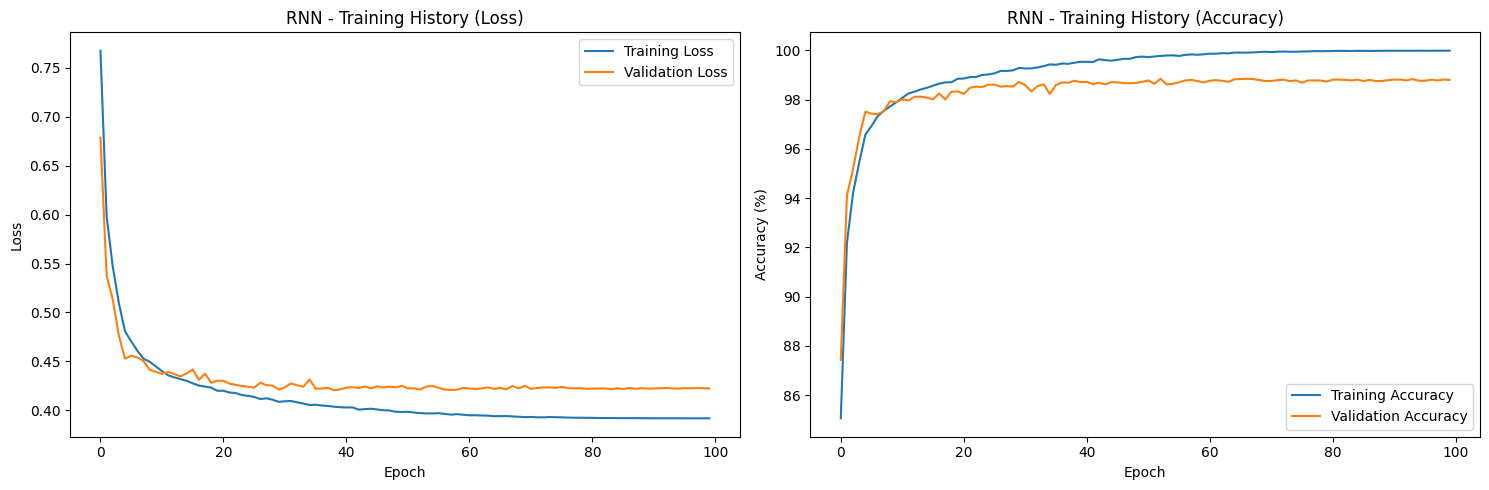

Testing: 100%|██████████| 343/343 [00:01<00:00, 314.94it/s]




Classification Report (RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.90      0.80      0.84       556
           2       0.96      0.97      0.97      1448
           3       0.86      0.82      0.84       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.91      0.93     21892
weighted avg       0.99      0.99      0.99     21892



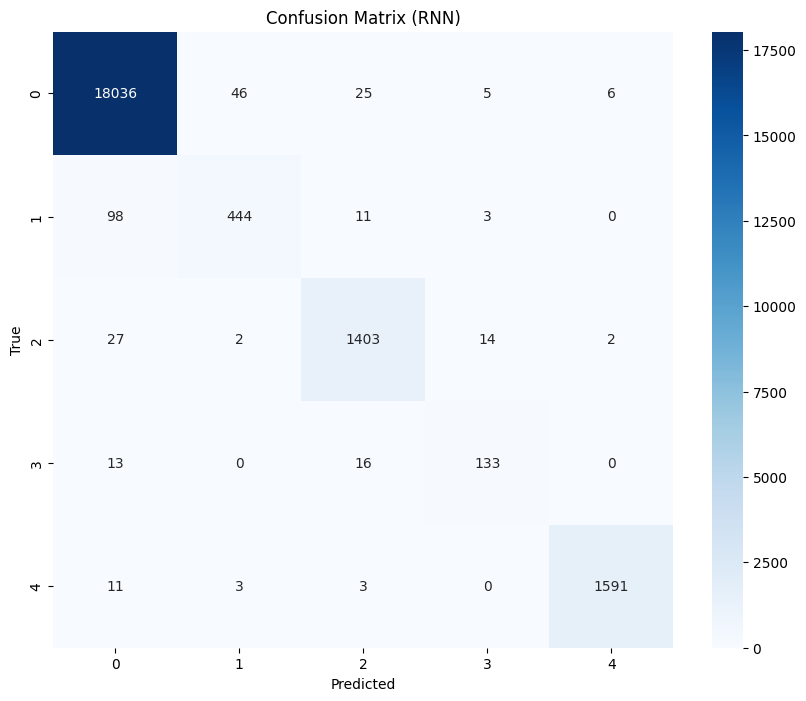

In [25]:
 # Update configuration based on actual data
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

# Update both model configurations
config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")

# Train models
rnn_trainer = train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [26]:
def get_test_accuracy(model, test_loader, device, model_name=''):
    model.eval()
    correct = 0
    total = 0
    
    print(f"\nEvaluating {model_name} model...")
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Handle different model outputs robustly (model may return logits or (logits, extra))
            result = model(batch_X)
            outputs = result[0] if isinstance(result, (tuple, list)) else result
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [27]:
# Create test loader
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get accuracies
rnn_accuracy = get_test_accuracy(rnn_trainer.model, test_loader, device, "RNN")

print("\nSummary:")
print(f"RNN Test Accuracy: {rnn_accuracy:.2f}%")


Evaluating RNN model...
RNN Test Accuracy: 98.70%

Summary:
RNN Test Accuracy: 98.70%
RNN Test Accuracy: 98.70%

Summary:
RNN Test Accuracy: 98.70%


In [28]:
#save RNN model
# torch.save(rnn_trainer.model.state_dict(), 'rnn_final_model.pth')

torch.save({
            'model_state_dict': rnn_trainer.model.state_dict(),
            'optimizer_state_dict': rnn_trainer.optimizer.state_dict(),
            'train_losses': rnn_trainer.train_losses,
            'val_losses': rnn_trainer.val_losses,
            'train_accuracies': rnn_trainer.train_accuracies,
            'val_accuracies': rnn_trainer.val_accuracies,
            'config': rnn_trainer.config
        }, 'rnn_final_model.pth')